# Probability of default (PD) model by Tensorflow&Keras 

## 1. Import library

In [2]:
import os
import h5py
import numpy as np
import tensorflow as tf
import time
import glob
import json
import csv
import pandas as pd
from pandas_summary import DataFrameSummary
import math, datetime

from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [3]:
import keras
from keras import applications
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D,Cropping2D, GRU, LSTM, Embedding
from keras.layers import Activation, Dropout, Flatten, Dense, Lambda, GlobalAveragePooling2D, BatchNormalization
from keras.utils.np_utils import to_categorical, normalize
from keras.models import Model
from keras.engine import Input

from keras import layers
from keras.optimizers import RMSprop

keras.__version__

Using TensorFlow backend.


'2.0.8'

## 2. Import data



### 2.1 Create dataframe by Pandas and take a look at the data

In [4]:
import os

fname = os.path.join('UCI_Credit_Card.csv')

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines)), print(len(header))

['"ID"', '"LIMIT_BAL"', '"SEX"', '"EDUCATION"', '"MARRIAGE"', '"AGE"', '"PAY_0"', '"PAY_2"', '"PAY_3"', '"PAY_4"', '"PAY_5"', '"PAY_6"', '"BILL_AMT1"', '"BILL_AMT2"', '"BILL_AMT3"', '"BILL_AMT4"', '"BILL_AMT5"', '"BILL_AMT6"', '"PAY_AMT1"', '"PAY_AMT2"', '"PAY_AMT3"', '"PAY_AMT4"', '"PAY_AMT5"', '"PAY_AMT6"', '"default.payment.next.month"']
30001
25


(None, None)

In [6]:
df = pd.read_csv(fname, low_memory=False) 
df
#df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0
5,6,50000.0,1,1,2,37,0,0,0,0,...,19394.0,19619.0,20024.0,2500.0,1815.0,657.0,1000.0,1000.0,800.0,0
6,7,500000.0,1,1,2,29,0,0,0,0,...,542653.0,483003.0,473944.0,55000.0,40000.0,38000.0,20239.0,13750.0,13770.0,0
7,8,100000.0,2,2,2,23,0,-1,-1,0,...,221.0,-159.0,567.0,380.0,601.0,0.0,581.0,1687.0,1542.0,0
8,9,140000.0,2,3,1,28,0,0,2,0,...,12211.0,11793.0,3719.0,3329.0,0.0,432.0,1000.0,1000.0,1000.0,0
9,10,20000.0,1,3,2,35,-2,-2,-2,-2,...,0.0,13007.0,13912.0,0.0,0.0,0.0,13007.0,1122.0,0.0,0


In [5]:
DataFrameSummary(df).summary()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
count,30000,30000,30000,30000,30000,30000,30000,30000,30000,30000,...,30000,30000,30000,30000,30000,30000,30000,30000,30000,30000
mean,15000.5,167484,1.60373,1.85313,1.55187,35.4855,-0.0167,-0.133767,-0.1662,-0.220667,...,43262.9,40311.4,38871.8,5663.58,5921.16,5225.68,4826.08,4799.39,5215.5,0.2212
std,8660.4,129748,0.489129,0.790349,0.52197,9.2179,1.1238,1.19719,1.19687,1.16914,...,64332.9,60797.2,59554.1,16563.3,23040.9,17607,15666.2,15278.3,17777.5,0.415062
min,1,10000,1,0,0,21,-2,-2,-2,-2,...,-170000,-81334,-339603,0,0,0,0,0,0,0
25%,7500.75,50000,1,1,1,28,-1,-1,-1,-1,...,2326.75,1763,1256,1000,833,390,296,252.5,117.75,0
50%,15000.5,140000,2,2,2,34,0,0,0,0,...,19052,18104.5,17071,2100,2009,1800,1500,1500,1500,0
75%,22500.2,240000,2,2,2,41,0,0,0,0,...,54506,50190.5,49198.2,5006,5000,4505,4013.25,4031.5,4000,0
max,30000,1e+06,2,6,3,79,8,8,8,8,...,891586,927171,961664,873552,1.68426e+06,896040,621000,426529,528666,1
counts,30000,30000,30000,30000,30000,30000,30000,30000,30000,30000,...,30000,30000,30000,30000,30000,30000,30000,30000,30000,30000
uniques,30000,81,2,7,4,56,11,11,11,11,...,21548,21010,20604,7943,7899,7518,6937,6897,6939,2


### 2.2 Convert data into a Numpy array

In [6]:
lines=lines[:-1]
print(len(lines))
print(np.shape(lines))
print(type(lines))
lines[0] 

30000
(30000,)
<class 'list'>


'1,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1'

In [7]:
float_data = np.zeros((len(lines), len(header) - 1))
print(np.shape(float_data))

(30000, 24)


In [8]:
lines[0]

'1,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1'

In [9]:
#Make numpy array and Delete ID No. 
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

In [10]:
float_data[0], np.shape(float_data),  type(float_data), 

(array([  2.00000000e+04,   2.00000000e+00,   2.00000000e+00,
          1.00000000e+00,   2.40000000e+01,   2.00000000e+00,
          2.00000000e+00,  -1.00000000e+00,  -1.00000000e+00,
         -2.00000000e+00,  -2.00000000e+00,   3.91300000e+03,
          3.10200000e+03,   6.89000000e+02,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          6.89000000e+02,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   1.00000000e+00]),
 (30000, 24),
 numpy.ndarray)

### 2.3  Prepare data with continuous variables 

In [11]:
# Delete SEX, EDUCATION, MARRIAGE, History of past payment, default.payment.next.month
con = np.delete(float_data, [1,2,3, 5,6,7,8,9,10,23], 1)
print(np.shape(con))
con[0:5]

(30000, 14)


array([[  2.00000000e+04,   2.40000000e+01,   3.91300000e+03,
          3.10200000e+03,   6.89000000e+02,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          6.89000000e+02,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00],
       [  1.20000000e+05,   2.60000000e+01,   2.68200000e+03,
          1.72500000e+03,   2.68200000e+03,   3.27200000e+03,
          3.45500000e+03,   3.26100000e+03,   0.00000000e+00,
          1.00000000e+03,   1.00000000e+03,   1.00000000e+03,
          0.00000000e+00,   2.00000000e+03],
       [  9.00000000e+04,   3.40000000e+01,   2.92390000e+04,
          1.40270000e+04,   1.35590000e+04,   1.43310000e+04,
          1.49480000e+04,   1.55490000e+04,   1.51800000e+03,
          1.50000000e+03,   1.00000000e+03,   1.00000000e+03,
          1.00000000e+03,   5.00000000e+03],
       [  5.00000000e+04,   3.70000000e+01,   4.69900000e+04,
          4.82330000e+04,   4.92910000e+04,   2.83140000e+0

###  2.4 Prepare data of categorical variables  

In [12]:
# Pick up SEX, EDUCATION, MARRIAGE, History of past payment
cat=float_data[:,[1,2,3,5,6,7,8,9,10]]
cat[0:5], np.shape(cat)

(array([[ 2.,  2.,  1.,  2.,  2., -1., -1., -2., -2.],
        [ 2.,  2.,  2., -1.,  2.,  0.,  0.,  0.,  2.],
        [ 2.,  2.,  2.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 2.,  2.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 1.,  2.,  1., -1.,  0., -1.,  0.,  0.,  0.]]), (30000, 9))

In [13]:
# one-hot coding
for i in range(np.shape(cat)[1]):
    if i==0:
      cate=to_categorical(cat[:,i])
    else:
      a=to_categorical(cat[:,i])
      cate=np.concatenate([cate, a], axis=1)
    
print((cate))
print(np.shape(cate))
print(type(cate))

[[ 0.  0.  1. ...,  0.  1.  0.]
 [ 0.  0.  1. ...,  0.  0.  0.]
 [ 0.  0.  1. ...,  0.  0.  0.]
 ..., 
 [ 0.  1.  0. ...,  0.  0.  0.]
 [ 0.  1.  0. ...,  0.  0.  1.]
 [ 0.  1.  0. ...,  0.  0.  0.]]
(30000, 68)
<class 'numpy.ndarray'>


### 2.5  Concatenate categorical data to continuous data

In [14]:
X=np.concatenate([cate, con], axis=1)
print((X[0]))
print(np.shape(X))
print(type(X))

[  0.00000000e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   1.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   1.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   1.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   1.00000000e+00

###  2.6 Prepare target as one-hot coding

In [15]:
Y=float_data[:,-1]
Y = to_categorical(Y)
Y, np.shape(Y)

(array([[ 0.,  1.],
        [ 0.,  1.],
        [ 1.,  0.],
        ..., 
        [ 0.,  1.],
        [ 0.,  1.],
        [ 0.,  1.]]), (30000, 2))

### 2.7  Separate traning data and test data

In [16]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.2, random_state=42)

In [17]:
np.shape(Xtrain), np.shape(Xtest),np.shape(Ytrain), np.shape(Ytest)

((24000, 82), (6000, 82), (24000, 2), (6000, 2))

### 2.8 Normalize data

In [18]:
catXtrain=Xtrain[:,0:68]
conXtrain=Xtrain[:,68:]
catXtest=Xtest[:,0:68]
conXtest=Xtest[:,68:]

In [19]:
## Normlization
mean = conXtrain.mean(axis=0)
conXtrain -= mean
std = conXtrain.std(axis=0)
conXtrain /= std
conXtest -= mean
conXtest /= std

In [20]:
#  Concatenate categorical data to continuous data

Xtrain=np.concatenate([catXtrain, conXtrain], axis=1)
#print((X[0]))
print(np.shape(Xtrain))
print(type(Xtrain))

Xtest=np.concatenate([catXtest, conXtest], axis=1)
print((X[0]))
print(np.shape(Xtest))
print(type(Xtest))

(24000, 82)
<class 'numpy.ndarray'>
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   1.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   1.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   1.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+0

## 3. Create and train neural network model

In [34]:
t=time.time()

model = Sequential()
model.add(Dense(32, input_shape=(82,), activation='relu'))
model.add(layers.BatchNormalization())
model.add(Dense(32, activation='relu'))
model.add(layers.BatchNormalization())
model.add(Dense(32, activation='relu'))
model.add(Dense(2, activation='softmax'))

filepath='PD32V1.{epoch:02d}-{val_acc:.2f}.hdf5'
mc_cb = keras.callbacks.ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='max')

model.compile(optimizer=RMSprop(lr=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(Xtrain, Ytrain, validation_data=[Xtest, Ytest],  batch_size=32, epochs=20, callbacks=[mc_cb])

t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict')

Train on 24000 samples, validate on 6000 samples
Epoch 1/20
24000/24000 [==============================] - 7s - loss: 0.9639 - acc: 0.4657 - val_loss: 0.5457 - val_acc: 0.7710
Epoch 2/20
24000/24000 [==============================] - 5s - loss: 0.5097 - acc: 0.7843 - val_loss: 0.4882 - val_acc: 0.7900
Epoch 3/20
24000/24000 [==============================] - 6s - loss: 0.4770 - acc: 0.7939 - val_loss: 0.4687 - val_acc: 0.7943
Epoch 4/20
24000/24000 [==============================] - 6s - loss: 0.4605 - acc: 0.8030 - val_loss: 0.4567 - val_acc: 0.8058
Epoch 5/20
24000/24000 [==============================] - 6s - loss: 0.4525 - acc: 0.8079 - val_loss: 0.4501 - val_acc: 0.8107
Epoch 6/20
24000/24000 [==============================] - 6s - loss: 0.4475 - acc: 0.8122 - val_loss: 0.4456 - val_acc: 0.8137
Epoch 7/20
24000/24000 [==============================] - 6s - loss: 0.4432 - acc: 0.8155 - val_loss: 0.4430 - val_acc: 0.8167
Epoch 8/20
24000/24000 [==============================] - 5s -

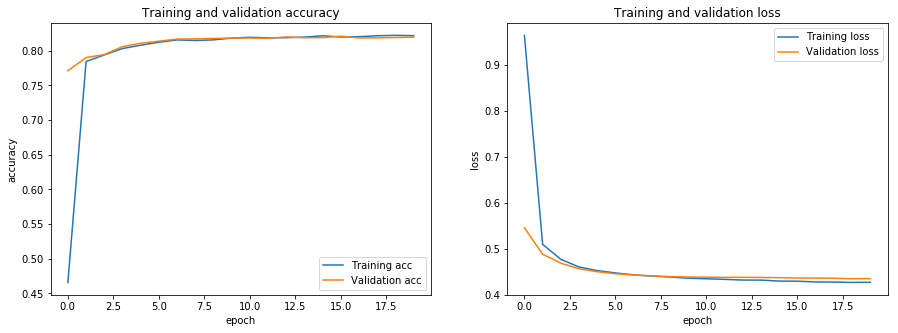

In [35]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
            
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

plt.show()

(1) Data :  Yeh, I. C., & Lien, C. H. (2009). The comparisons of data mining techniques for the predictive accuracy of probability of default of credit card clients. Expert Systems with Applications, 36(2), 2473-2480.


 ### This code is solely for educational purpose. The code cannot be used for investments or busineeses in practice. TOSHI STATS SDN. BHD. and I do not accept any responsibility or liability for loss or damage occasioned to any person or property through using materials, instructions, methods, algorithm or ideas contained herein, or acting or refraining from acting as a result of such use. TOSHI STATS SDN. BHD. and I expressly disclaim all implied warranties, including merchantability or fitness for any particular purpose. There will be no duty on TOSHI STATS SDN. BHD. and me to correct any errors or defects in the codes and the software.                    
